In [6]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [7]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [72]:
borrar = ["Opportunity_Name", "ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]
useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [73]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Concrete_Offer <= 0, "Concrete_Offer"] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Offer_Duration <= 0, "Offer_Duration"] = -1
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype("category")
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    rest = [x for x in data.columns if x not in ['ID']]
    data = data.drop_duplicates(rest)
    
    #data = data.groupby("Opportunity_ID", as_index = False).max()
    
    return (data)

In [74]:
df = preprocess(data)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A',
               'TRF_Cat']
categorical = [x for x in categorical if x in df.columns]

In [76]:
train_data = lgb.Dataset(x_train.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_test.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 40,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 1000, early_stopping_rounds = 300)

[1]	valid_0's binary_logloss: 0.674449
Training until validation scores don't improve for 300 rounds
[2]	valid_0's binary_logloss: 0.668953
[3]	valid_0's binary_logloss: 0.662929
[4]	valid_0's binary_logloss: 0.657388
[5]	valid_0's binary_logloss: 0.650809
[6]	valid_0's binary_logloss: 0.639455
[7]	valid_0's binary_logloss: 0.628234
[8]	valid_0's binary_logloss: 0.623002
[9]	valid_0's binary_logloss: 0.617589
[10]	valid_0's binary_logloss: 0.6068
[11]	valid_0's binary_logloss: 0.601777
[12]	valid_0's binary_logloss: 0.59663
[13]	valid_0's binary_logloss: 0.586609
[14]	valid_0's binary_logloss: 0.576792
[15]	valid_0's binary_logloss: 0.572146
[16]	valid_0's binary_logloss: 0.562737
[17]	valid_0's binary_logloss: 0.553576
[18]	valid_0's binary_logloss: 0.544389
[19]	valid_0's binary_logloss: 0.535639
[20]	valid_0's binary_logloss: 0.527073
[21]	valid_0's binary_logloss: 0.523537
[22]	valid_0's binary_logloss: 0.519417
[23]	valid_0's binary_logloss: 0.51578
[24]	valid_0's binary_logloss: 

[212]	valid_0's binary_logloss: 0.162299
[213]	valid_0's binary_logloss: 0.161059
[214]	valid_0's binary_logloss: 0.159888
[215]	valid_0's binary_logloss: 0.159583
[216]	valid_0's binary_logloss: 0.159282
[217]	valid_0's binary_logloss: 0.159047
[218]	valid_0's binary_logloss: 0.157917
[219]	valid_0's binary_logloss: 0.156799
[220]	valid_0's binary_logloss: 0.156553
[221]	valid_0's binary_logloss: 0.156312
[222]	valid_0's binary_logloss: 0.156039
[223]	valid_0's binary_logloss: 0.154974
[224]	valid_0's binary_logloss: 0.153965
[225]	valid_0's binary_logloss: 0.152924
[226]	valid_0's binary_logloss: 0.151809
[227]	valid_0's binary_logloss: 0.151601
[228]	valid_0's binary_logloss: 0.150593
[229]	valid_0's binary_logloss: 0.150387
[230]	valid_0's binary_logloss: 0.150181
[231]	valid_0's binary_logloss: 0.149998
[232]	valid_0's binary_logloss: 0.149814
[233]	valid_0's binary_logloss: 0.149603
[234]	valid_0's binary_logloss: 0.148565
[235]	valid_0's binary_logloss: 0.148365
[236]	valid_0's 

[418]	valid_0's binary_logloss: 0.0986295
[419]	valid_0's binary_logloss: 0.0985891
[420]	valid_0's binary_logloss: 0.0985474
[421]	valid_0's binary_logloss: 0.0984576
[422]	valid_0's binary_logloss: 0.098406
[423]	valid_0's binary_logloss: 0.0981136
[424]	valid_0's binary_logloss: 0.0978121
[425]	valid_0's binary_logloss: 0.0975277
[426]	valid_0's binary_logloss: 0.0974501
[427]	valid_0's binary_logloss: 0.0971567
[428]	valid_0's binary_logloss: 0.097062
[429]	valid_0's binary_logloss: 0.0970429
[430]	valid_0's binary_logloss: 0.0969502
[431]	valid_0's binary_logloss: 0.096713
[432]	valid_0's binary_logloss: 0.0967004
[433]	valid_0's binary_logloss: 0.0964371
[434]	valid_0's binary_logloss: 0.0963936
[435]	valid_0's binary_logloss: 0.0961236
[436]	valid_0's binary_logloss: 0.0960524
[437]	valid_0's binary_logloss: 0.0958233
[438]	valid_0's binary_logloss: 0.0955603
[439]	valid_0's binary_logloss: 0.0953414
[440]	valid_0's binary_logloss: 0.095304
[441]	valid_0's binary_logloss: 0.0950

[620]	valid_0's binary_logloss: 0.0827618
[621]	valid_0's binary_logloss: 0.0826745
[622]	valid_0's binary_logloss: 0.0825506
[623]	valid_0's binary_logloss: 0.0825256
[624]	valid_0's binary_logloss: 0.0824733
[625]	valid_0's binary_logloss: 0.0824561
[626]	valid_0's binary_logloss: 0.0823636
[627]	valid_0's binary_logloss: 0.0823097
[628]	valid_0's binary_logloss: 0.0822943
[629]	valid_0's binary_logloss: 0.0822724
[630]	valid_0's binary_logloss: 0.0821706
[631]	valid_0's binary_logloss: 0.0821047
[632]	valid_0's binary_logloss: 0.0820499
[633]	valid_0's binary_logloss: 0.0819139
[634]	valid_0's binary_logloss: 0.0818484
[635]	valid_0's binary_logloss: 0.0817869
[636]	valid_0's binary_logloss: 0.0816901
[637]	valid_0's binary_logloss: 0.0816349
[638]	valid_0's binary_logloss: 0.0815634
[639]	valid_0's binary_logloss: 0.0814939
[640]	valid_0's binary_logloss: 0.081411
[641]	valid_0's binary_logloss: 0.0813729
[642]	valid_0's binary_logloss: 0.0812966
[643]	valid_0's binary_logloss: 0.0

[843]	valid_0's binary_logloss: 0.0757793
[844]	valid_0's binary_logloss: 0.0757786
[845]	valid_0's binary_logloss: 0.0757698
[846]	valid_0's binary_logloss: 0.0757769
[847]	valid_0's binary_logloss: 0.0757962
[848]	valid_0's binary_logloss: 0.0757803
[849]	valid_0's binary_logloss: 0.0757712
[850]	valid_0's binary_logloss: 0.0757762
[851]	valid_0's binary_logloss: 0.0757687
[852]	valid_0's binary_logloss: 0.075763
[853]	valid_0's binary_logloss: 0.0757689
[854]	valid_0's binary_logloss: 0.075766
[855]	valid_0's binary_logloss: 0.0757798
[856]	valid_0's binary_logloss: 0.0758017
[857]	valid_0's binary_logloss: 0.0758037
[858]	valid_0's binary_logloss: 0.0757854
[859]	valid_0's binary_logloss: 0.0757648
[860]	valid_0's binary_logloss: 0.0757882
[861]	valid_0's binary_logloss: 0.0757396
[862]	valid_0's binary_logloss: 0.0757382
[863]	valid_0's binary_logloss: 0.0757613
[864]	valid_0's binary_logloss: 0.0757513
[865]	valid_0's binary_logloss: 0.0757331
[866]	valid_0's binary_logloss: 0.07

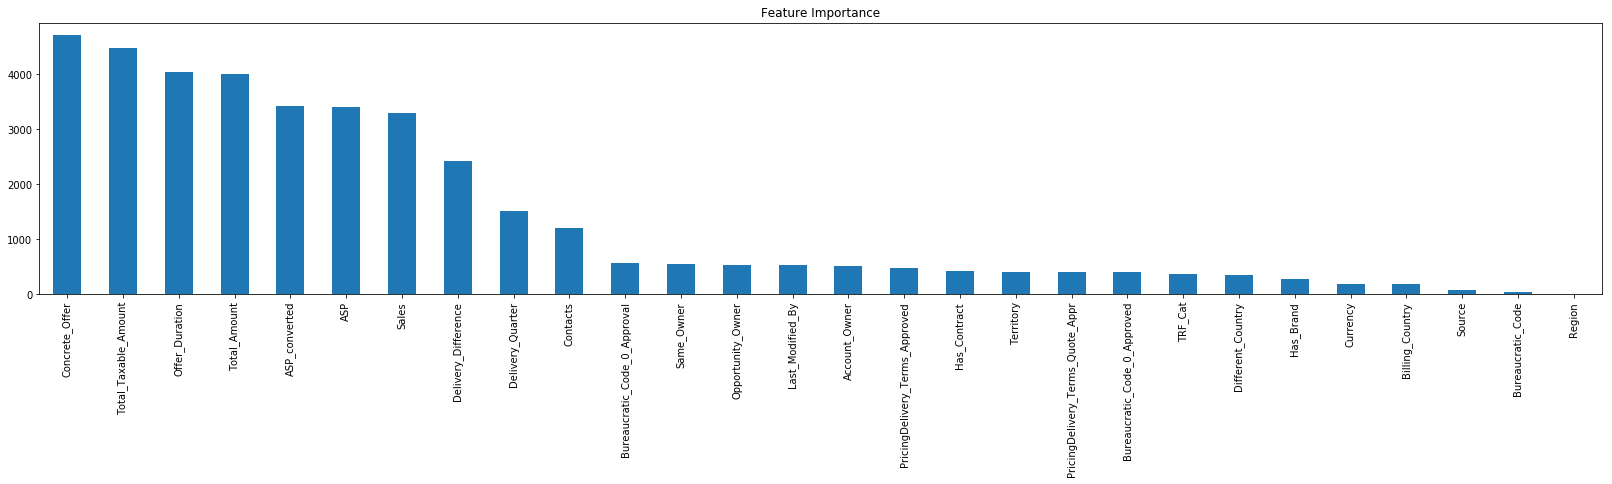

In [13]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

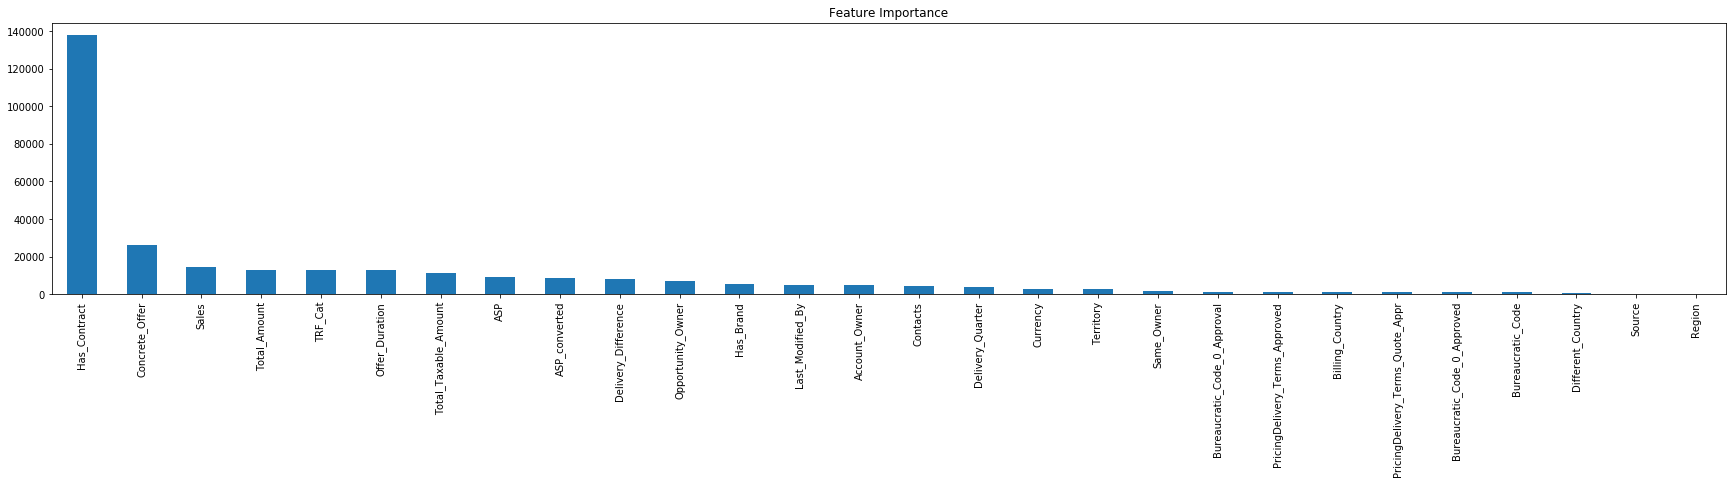

In [14]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [15]:
print feat_imp

Has_Contract                        137562.907379
Concrete_Offer                       26267.236118
Sales                                14345.286918
Total_Amount                         13092.724685
TRF_Cat                              12901.833920
Offer_Duration                       12685.580580
Total_Taxable_Amount                 11064.168200
ASP                                   9281.923615
ASP_converted                         8817.536120
Delivery_Difference                   8363.623890
Opportunity_Owner                     7034.591587
Has_Brand                             5669.459427
Last_Modified_By                      5195.736065
Account_Owner                         4713.836433
Contacts                              4351.787286
Delivery_Quarter                      3687.195004
Currency                              3060.758762
Territory                             2832.554447
Same_Owner                            1610.229102
Bureaucratic_Code_0_Approval          1483.531253


In [79]:
y_pred = model.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_ttest = x_test.join(pred)
answer = x_ttest.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [80]:
log_loss(answer["Stage"], answer["Prediction"])

0.08088177099420676

In [69]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)

In [536]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9938910642742124

In [30]:
data[(data.Billing_Country != data.Territory) & (data.Territory != "None")].groupby("Stage")["Stage"].count()

Stage
0    2323
1    2225
Name: Stage, dtype: int64

In [31]:
data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")

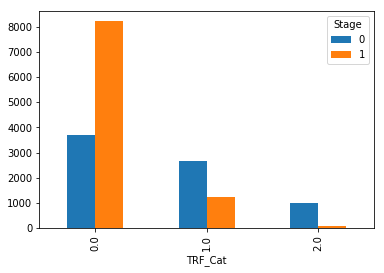

In [34]:
pd.crosstab(data.TRF_Cat, data.Stage).plot(kind = "bar")

In [7]:
df.groupby("Sales_Contract_No")["Sales_Contract_No"].count()

Sales_Contract_No
0          1
1          1
10         1
100        7
1000       1
1001       2
1002       1
1003       5
1004       5
1005       5
1006       5
1007       5
1008       1
1009       1
101        1
1010       2
1011       1
1012       1
1013       2
1014       1
1015       2
1016       2
1017       1
1018       2
1019       3
102        1
1020       1
1021       2
1022       1
1023       2
1024       2
1025       1
1026       2
1027       1
1028       2
1029       2
103        1
1030       2
1031       1
1032       1
1033       1
1034       1
1035       2
1036       1
1037       1
1038       1
1039       1
104        1
1040       1
1041       1
        ... 
954        2
955        1
956        1
958        1
959        1
96         1
960        1
961        1
962        1
963        1
964        1
965        1
966        1
967        1
968        1
969        1
97         3
970        1
971        1
972        1
973        1
974        1
975        1
976        2
977    

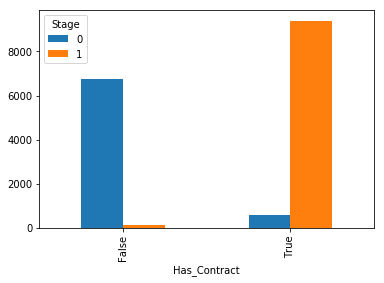

In [7]:
pd.crosstab(df.Has_Contract, df.Stage).plot(kind = "bar")

In [419]:
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A',
               'TRF_Cat']
categorical = [x for x in categorical if x in df.columns]

full_data = lgb.Dataset(df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

full_model = lgb.train(parameters, full_data, num_boost_round = 5000)

In [420]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = full_model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer2 = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer2["Prediction"])

0.9910109044758247

In [421]:
answer2["Prediction"].corr(answer["Prediction"])

0.9923094924130285

In [527]:
answer.to_csv("submission_15.csv", header = False, index = False)

In [28]:
df["Product_Offer"] = df.groupby("Product_Family", sort = False)["Product_Family"].transform("count")

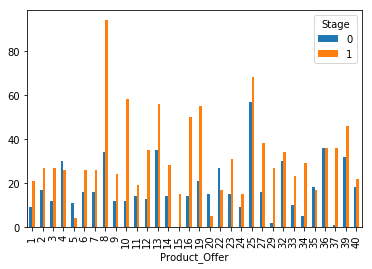

In [31]:
pd.crosstab(df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Product_Offer, df[(df.Product_Offer <= 40) & (df.Product_Offer <= 40)].Stage).plot(kind = "bar")

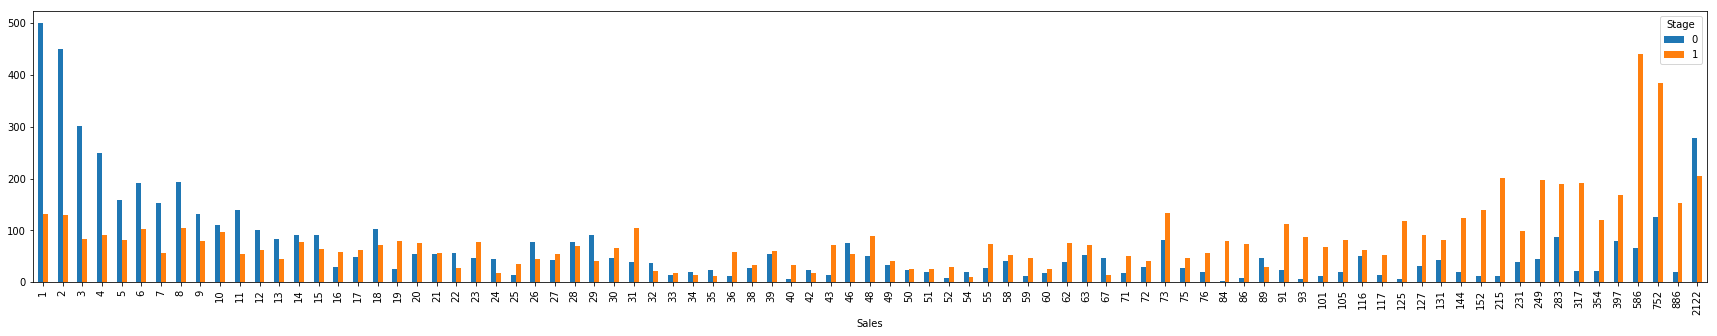

In [194]:
pd.crosstab(df.Sales, df.Stage).plot(kind = "bar")

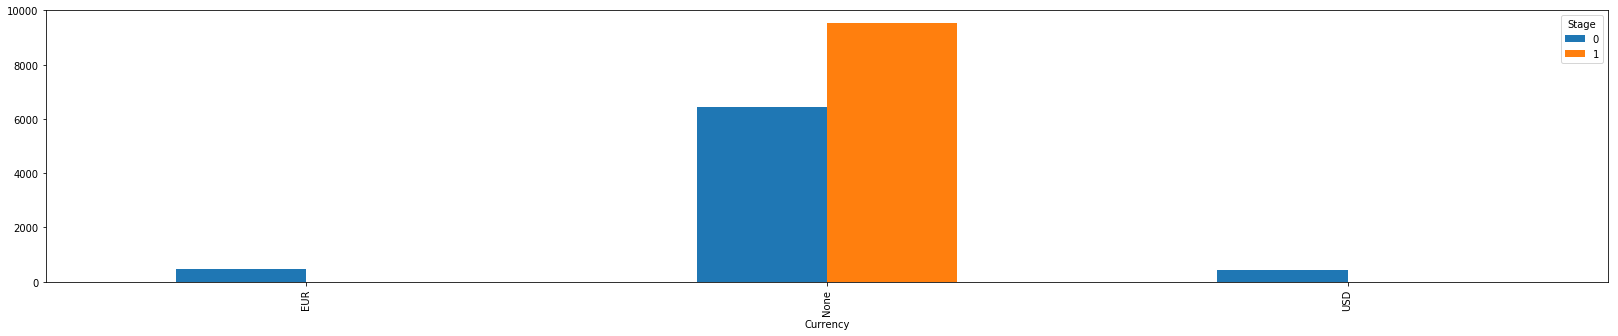

In [16]:
pd.crosstab(df.Currency, df.Stage).plot(kind = "bar")

In [246]:
dff = df.groupby("Opportunity_ID", as_index = False).max()

In [247]:
dff

,Opportunity_ID,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,ASP,ASP_converted,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
0,0,1,1,1,1,0.5200,0.58817,5272800.00,5272800.00,0,1,60.0,True,False,False,False,2.0,63
1,1,0,0,0,0,0.5300,0.59948,48230.00,48230.00,1,1,2.0,True,False,True,False,0.0,63
2,2,0,0,0,0,0.4800,0.48000,83865.60,83865.60,1,1,0.0,True,False,True,True,0.0,91
3,3,1,0,1,0,0.5300,0.53000,7421881.50,7421881.50,0,1,58.0,True,True,False,True,2.0,8
4,4,1,0,1,0,0.5300,0.53000,13357192.50,13357192.50,0,1,27.0,True,True,False,True,2.0,8
5,5,1,0,1,0,0.5300,0.53000,14838277.50,14838277.50,0,1,58.0,True,True,False,True,2.0,8
6,6,1,0,1,0,0.3800,0.38000,2659494.60,2659494.60,0,1,89.0,True,False,False,True,1.0,8
7,7,1,1,1,1,0.4800,0.48000,50688.00,50688.00,1,1,0.0,True,False,False,True,0.0,91
8,8,1,0,0,0,78.0000,0.70125,304200.00,470400.00,0,5,0.0,True,False,False,False,0.0,2122
9,9,1,0,0,0,78.0000,0.70125,385320.00,559320.00,0,5,0.0,True,False,False,False,0.0,2122


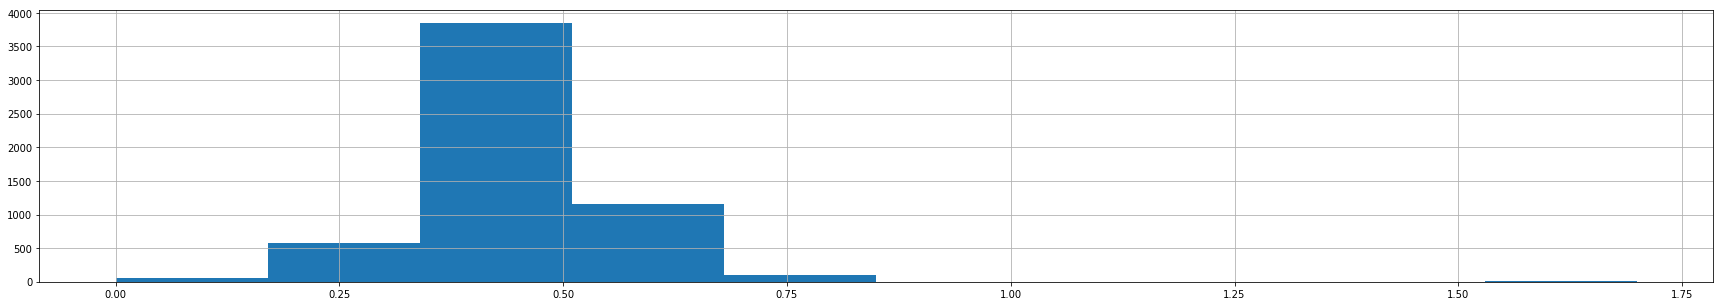

In [334]:
df[(df.Stage == 0) & (df.ASP_converted < 10)].ASP_converted.hist()

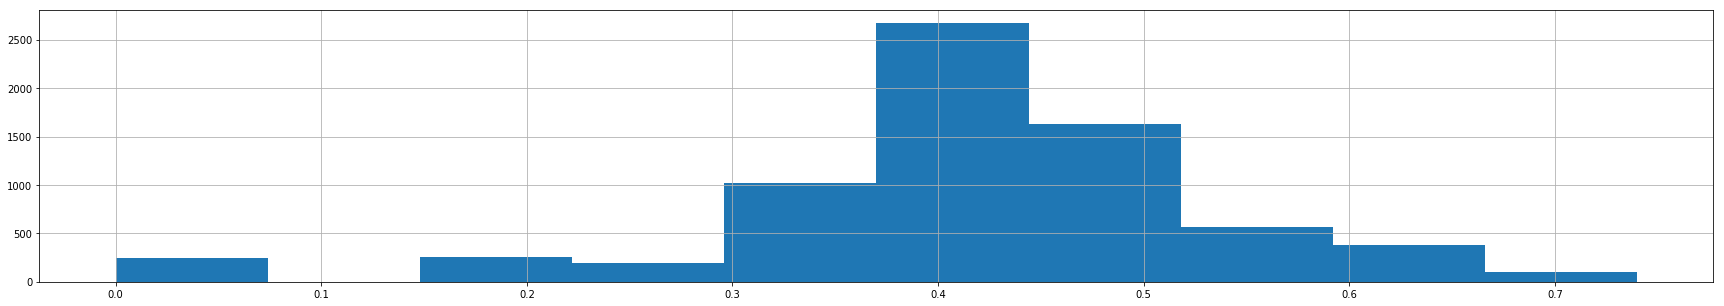

In [335]:
df[(df.Stage == 1) & (df.ASP_converted < 10)].ASP_converted.hist()

In [341]:
df[df.ASP >= 100]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales


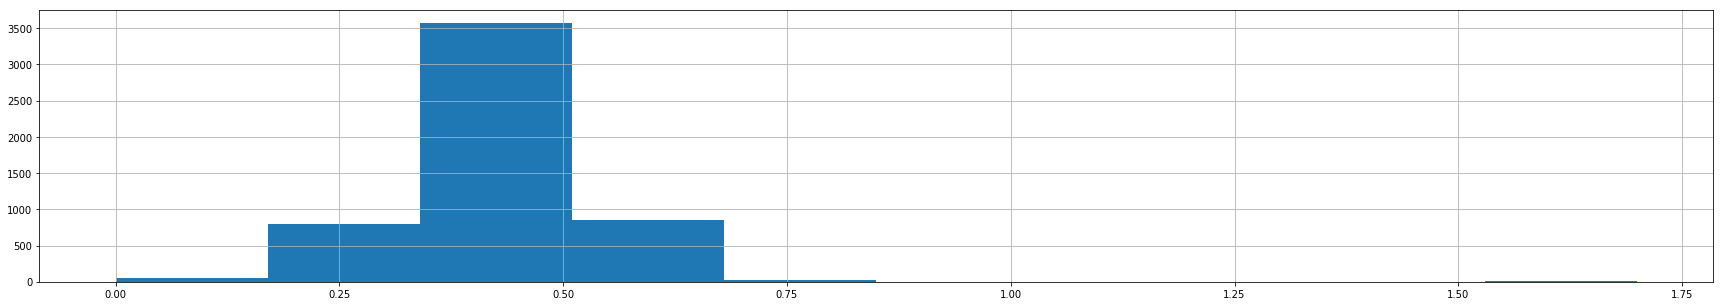

In [338]:
df[(df.Stage == 0) & (df.ASP < 10)].ASP.hist()

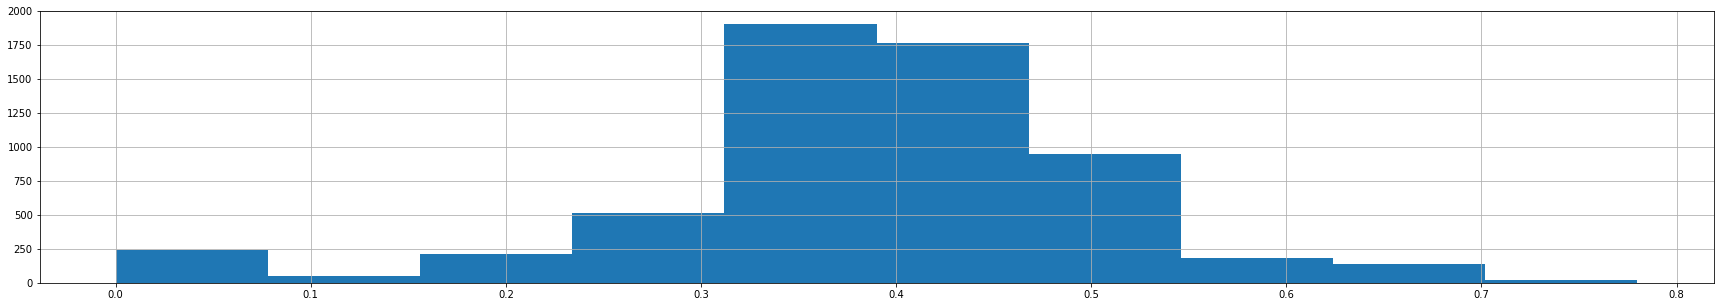

In [339]:
df[(df.Stage == 1) & (df.ASP < 10)].ASP.hist()

In [377]:
validation.loc[validation.Contacts > 1,["Opportunity_ID", "Total_Amount", "Prediction"]]

,Opportunity_ID,Total_Amount,Prediction
0,10689,162240.00,9.998427e-01
1,10689,78624.00,9.999800e-01
2,10689,126555.00,9.999641e-01
3,10690,243360.00,9.991531e-01
4,10690,157248.00,9.996472e-01
5,10690,126555.00,9.999089e-01
6,10690,118156.50,9.999394e-01
7,10690,112464.00,9.999438e-01
9,10692,342490.50,8.214472e-01
12,10692,456654.00,8.975898e-01


In [380]:
validation[(0.2 <= validation.Prediction) & (validation.Prediction <= 0.8)]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Prediction
74,Japan,Japan,1,1,0,0,Bureaucratic_Code_4,None,Japan,10730,None,Person_Name_55,Person_Name_55,None,Person_Name_28,0.000,0.00000,Q2,11020.00,11020.00,1,0.0,False,False,False,False,0.0,25,0.274020
106,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10751,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.305,0.34498,Q2,229811.40,229811.40,1,5.0,True,False,False,False,1.0,3,0.530910
107,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10752,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.305,0.34498,Q2,229811.40,229811.40,1,5.0,True,False,False,False,1.0,3,0.530910
108,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,None,Germany,10753,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.300,0.33933,Q2,135408.00,135408.00,1,18.0,True,False,False,False,0.0,3,0.244937
414,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,10935,5782,Person_Name_45,Person_Name_45,None,Person_Name_45,0.340,0.34000,Q2,67235.00,67235.00,1,0.0,True,False,True,True,0.0,6,0.715488
418,APAC,Philippines,0,0,0,0,Bureaucratic_Code_4,Source_11,Philippines,10938,6431,Person_Name_65,Person_Name_65,None,Person_Name_65,0.400,0.40000,Q2,400000.00,400000.00,1,60.0,True,False,True,False,1.0,1,0.649483
530,Americas,Central US,1,1,1,1,Bureaucratic_Code_4,None,United States,11002,5789,Person_Name_64,Person_Name_45,None,Person_Name_45,0.425,0.42500,Q1,125664.00,125664.00,1,NaN,True,False,True,True,0.0,2,0.716779
547,Americas,Central US,1,1,1,1,Bureaucratic_Code_4,None,United States,11011,5802,Person_Name_45,Person_Name_45,None,Person_Name_45,0.425,0.42500,Q1,44880.00,44880.00,1,0.0,True,False,True,True,0.0,2,0.625493
599,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,11048,6418,Person_Name_45,Person_Name_45,None,Person_Name_45,0.490,0.49000,Q2,45570.00,45570.00,1,NaN,True,False,True,True,0.0,2,0.698614
657,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,None,United States,11085,5837,Person_Name_45,Person_Name_45,None,Person_Name_45,0.385,0.38500,Q1,67654.13,69222.13,2,NaN,True,False,True,True,0.0,3,0.325935


In [381]:
vali[vali.Opportunity_ID == 12308]

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
2474,7518,Americas,Central US,1,1,0,0,0,Bureaucratic_Code_4,8/11/2017,None,United States,Account_Name_156,Opportunity_Name_9042,12308,6495,Person_Name_45,Person_Name_45,Account_Type_2,Opportunity_Type_7,Non Binding,Delivery_Terms_6,4/23/2019,None,None,None,None,None,None,NaT,NaT,4/24/2019,Person_Name_45,Product_Family_168,Product_Name_322,USD,0.435,USD,0.435,10/1/2019,NaT,2019 - 10,Q4,2019,NaT,0,USD,64310.4,USD,64310.4,Prod_Category_A_None


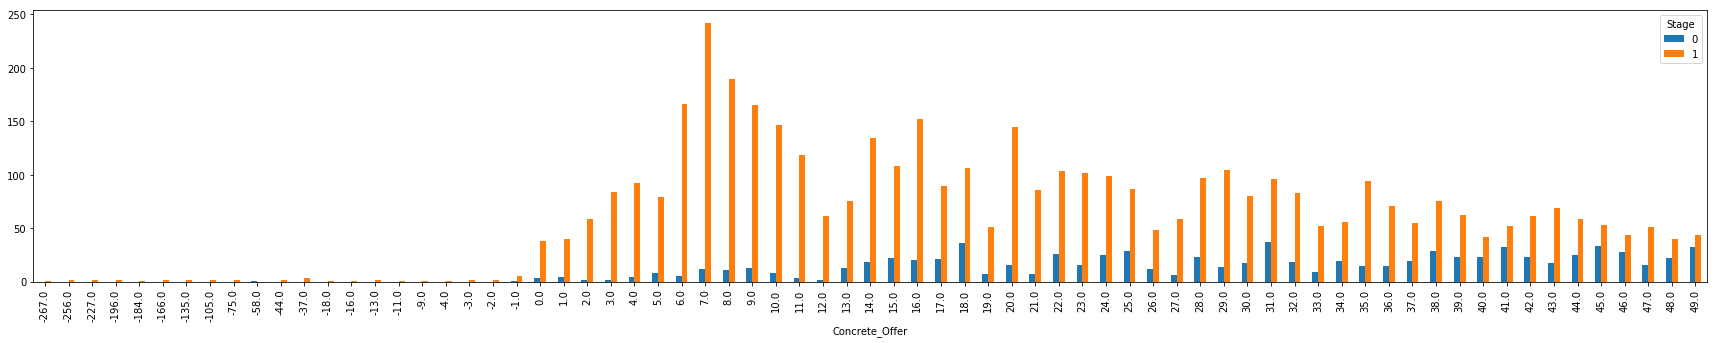

In [517]:
pd.crosstab(df[(df.Concrete_Offer < 50) & (df.Concrete_Offer < 50)].Concrete_Offer, df[(df.Concrete_Offer < 50) & (df.Concrete_Offer < 50)].Stage).plot(kind = "bar")

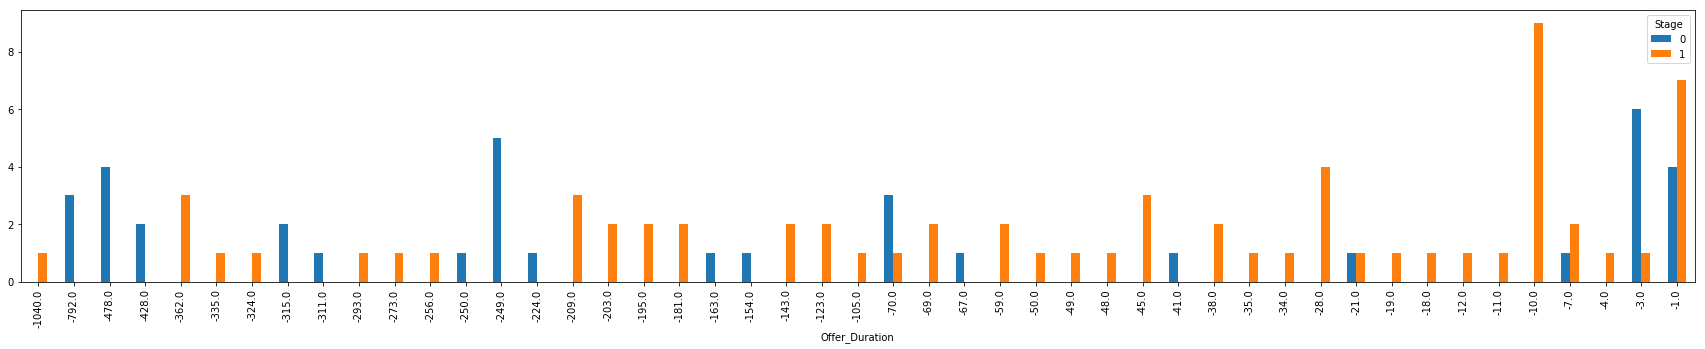

In [522]:
pd.crosstab(df[(df.Offer_Duration < 0) & (df.Offer_Duration < 0)].Offer_Duration, df[(df.Offer_Duration < 0) & (df.Offer_Duration < 0)].Stage).plot(kind = "bar")

In [481]:
full_data = lgb.Dataset(data = df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

cv_results = lgb.cv(parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)

In [483]:
cv_results["binary_logloss-mean"][-1]

0.07836245142644821

In [497]:
data.describe(include = "all")

,ID,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_converted_Currency,ASP_converted,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
count,16883.000000,16883,16883,16883.000000,16883.000000,16883.000000,16883.000000,16883.0,16883,16883,16883,16883,16883,16883,16883.000000,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,13679.000000,16883,13679.000000,16883,16883,16883,16883,16883.000000,16883,16883.000000,16883,1.682400e+04,16883,1.688300e+04,16883.000000,16883
unique,NaN,5,75,NaN,NaN,NaN,NaN,NaN,7,800,14,79,1620,9791,NaN,5267,48,53,7,25,2,9,1096,26,7,7,28,53,3,1,996,649,53,225,446,5,NaN,1,NaN,968,1001,45,4,NaN,1,NaN,5,NaN,5,NaN,NaN,1
top,NaN,Japan,None,NaN,NaN,NaN,NaN,NaN,Bureaucratic_Code_4,4/20/2015,None,Japan,Account_Name_1888,Opportunity_Name_9795,NaN,None,Person_Name_50,Person_Name_50,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_4,6/30/2017,None,None,None,None,None,None,NaT,NaT,2/8/2018,Person_Name_47,Product_Family_77,Product_Name_100,USD,NaN,USD,NaN,3/31/2016,3/31/2016,2018 - 10,Q2,NaN,NaT,NaN,USD,NaN,USD,NaN,NaN,Prod_Category_A_None
freq,NaN,4869,4981,NaN,NaN,NaN,NaN,NaN,12544,3009,9454,4856,2122,36,NaN,6909,3722,3773,8786,6774,16713,7682,124,15847,15871,15903,15864,15918,15988,16883,4594,5820,8514,1345,976,7321,NaN,16883,NaN,381,451,666,4423,NaN,16883,NaN,7321,NaN,7305,NaN,NaN,16883
mean,17689.638453,NaN,NaN,0.807262,0.583249,0.473494,0.317538,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5317.061956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.977507,NaN,0.432941,NaN,NaN,NaN,NaN,2017.129657,NaN,2.335841,NaN,1.784533e+06,NaN,3.095833e+06,0.564651,NaN
std,6938.726406,NaN,NaN,0.394461,0.493035,0.499312,0.465533,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3316.269606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.849489,NaN,0.760244,NaN,NaN,NaN,NaN,0.820929,NaN,12.186565,NaN,1.302066e+07,NaN,1.854964e+07,0.495817,NaN
min,4854.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,2016.000000,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,0.000000,NaN
25%,12013.500000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2438.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360000,NaN,0.375000,NaN,NaN,NaN,NaN,2016.000000,NaN,0.000000,NaN,2.660000e+04,NaN,8.540752e+04,0.000000,NaN
50%,18152.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5295.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,0.412850,NaN,NaN,NaN,NaN,2017.000000,NaN,0.000000,NaN,1.069790e+05,NaN,3.753945e+05,1.000000,NaN
75%,23900.500000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7664.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.505000,NaN,0.476490,NaN,NaN,NaN,NaN,2018.000000,NaN,1.000000,NaN,4.540625e+05,NaN,1.031472e+06,1.000000,NaN


In [503]:
data.loc[data.Quote_Expiry_Date != "NaT", dates + ["Stage"]]

,Account_Created_Date,Opportunity_Created_Date,Quote_Expiry_Date,Last_Modified_Date,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Stage
0,6/16/2015,12/7/2015,1/30/2016,6/13/2016,5/1/2016,6/30/2016,0
1,6/16/2015,12/7/2015,1/20/2016,1/15/2016,1/18/2016,1/20/2016,1
2,4/21/2015,12/8/2015,9/30/2016,9/29/2016,1/25/2016,1/25/2016,1
4,7/27/2013,12/8/2015,6/2/2017,3/27/2018,2/1/2018,2/28/2018,0
5,7/27/2013,12/8/2015,6/2/2017,3/27/2018,2/1/2018,3/31/2018,0
7,4/21/2015,12/9/2015,1/7/2016,12/9/2015,1/25/2016,1/25/2016,1
23,10/13/2015,12/9/2015,3/31/2016,1/7/2016,1/9/2016,1/15/2016,1
24,12/9/2015,12/9/2015,3/31/2016,3/30/2016,1/18/2016,1/31/2016,0
62,7/27/2013,12/9/2015,12/23/2015,10/28/2016,4/11/2016,4/15/2016,0
63,7/27/2013,12/9/2015,1/8/2016,12/9/2015,1/18/2016,1/29/2016,1


In [27]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins = 30)

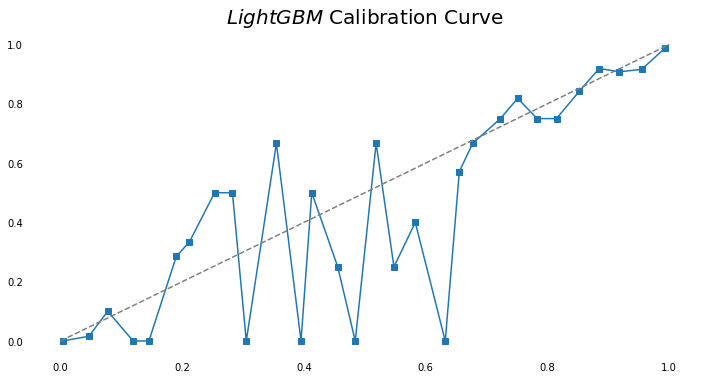

In [28]:
pltt = plt.pyplot
fig, ax = pltt.subplots(1, figsize = (12, 6))
pltt.plot(mean_predicted_value, fraction_of_positives, 's-')
pltt.plot([0, 1], [0, 1], '--', color = 'gray')

sns.despine(left = True, bottom = True)
pltt.gca().xaxis.set_ticks_position('none')
pltt.gca().yaxis.set_ticks_position('none')
pltt.title("$LightGBM$ Calibration Curve", fontsize = 20); pass

In [26]:
from sklearn.metrics import confusion_matrix
y_pred_def = np.where(y_pred > 0.5, 1, 0)
confusion_matrix(y_test, y_pred_def)

array([[1694,   73],
       [  12, 2189]])

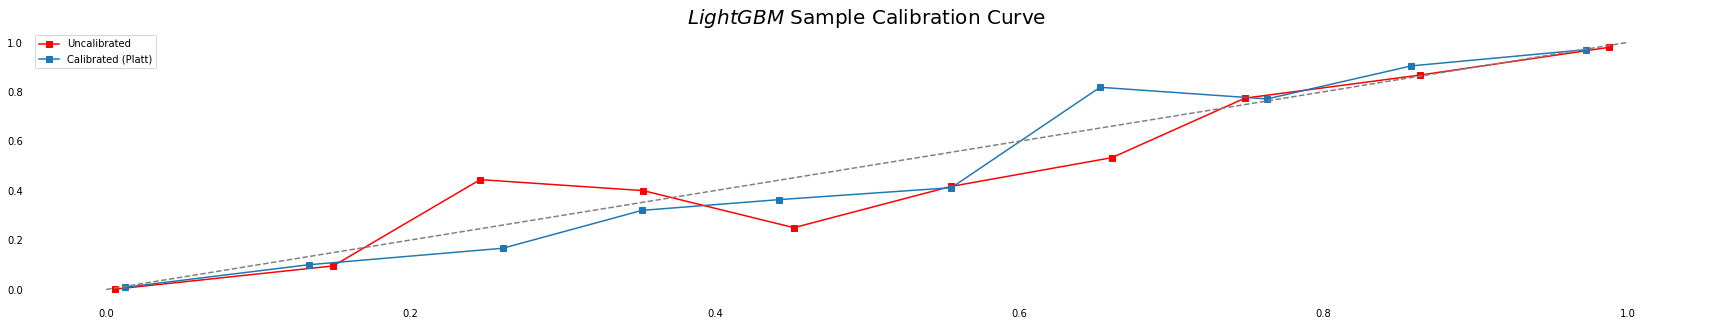

In [55]:
from sklearn.calibration import CalibratedClassifierCV
pltt = plt.pyplot

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins = 10)

pltt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')

# Create a corrected classifier.
clf = lgb.LGBMClassifier().set_params(**parameters)
clf_sigmoid = CalibratedClassifierCV(clf, cv = 5, method = 'isotonic')
clf_sigmoid.fit(x_train.drop(target + cat_vars, axis = 1), y_train)
y_test_predict_proba = clf_sigmoid.predict_proba(x_test.drop(target + cat_vars + ["Prediction"], axis = 1))[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins = 10)

pltt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibrated (Platt)')
pltt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
pltt.gca().xaxis.set_ticks_position('none')
pltt.gca().yaxis.set_ticks_position('none')
pltt.gca().legend()
pltt.title("$LightGBM$ Sample Calibration Curve", fontsize=20); pass

In [38]:
cat_vars = [x for x in x_train.select_dtypes('category').columns if x != 'Stage']

In [56]:
y_test_predict_proba

array([0.        , 0.        , 0.98725389, ..., 0.99173075, 0.04271839,
       0.03160151])

In [57]:
log_loss(y_test, y_test_predict_proba)

0.11978329486208197

In [77]:
y_pred = model.predict(x_train.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_train.index, columns = ["Prediction"])
x_t = x_train.join(pred)
ans = x_t.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(ans["Stage"], ans["Prediction"])

0.016727998980082245

In [81]:
train_data = lgb.Dataset(x_t.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_ttest.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 20,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'max_bin': 200,
    'verbose': 0
}

model2 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 500, early_stopping_rounds = 100)

[1]	valid_0's binary_logloss: 0.645296
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.631906
[3]	valid_0's binary_logloss: 0.591042
[4]	valid_0's binary_logloss: 0.558183
[5]	valid_0's binary_logloss: 0.523974
[6]	valid_0's binary_logloss: 0.492772
[7]	valid_0's binary_logloss: 0.464137
[8]	valid_0's binary_logloss: 0.43781
[9]	valid_0's binary_logloss: 0.416525
[10]	valid_0's binary_logloss: 0.393945
[11]	valid_0's binary_logloss: 0.373017
[12]	valid_0's binary_logloss: 0.356031
[13]	valid_0's binary_logloss: 0.348297
[14]	valid_0's binary_logloss: 0.333106
[15]	valid_0's binary_logloss: 0.319053
[16]	valid_0's binary_logloss: 0.31422
[17]	valid_0's binary_logloss: 0.308857
[18]	valid_0's binary_logloss: 0.296125
[19]	valid_0's binary_logloss: 0.291494
[20]	valid_0's binary_logloss: 0.286778
[21]	valid_0's binary_logloss: 0.281735
[22]	valid_0's binary_logloss: 0.276966
[23]	valid_0's binary_logloss: 0.264012
[24]	valid_0's binary_logloss

[201]	valid_0's binary_logloss: 0.106693
[202]	valid_0's binary_logloss: 0.107462
[203]	valid_0's binary_logloss: 0.107618
[204]	valid_0's binary_logloss: 0.107702
[205]	valid_0's binary_logloss: 0.108227
[206]	valid_0's binary_logloss: 0.108436
[207]	valid_0's binary_logloss: 0.108372
[208]	valid_0's binary_logloss: 0.108363
[209]	valid_0's binary_logloss: 0.109133
[210]	valid_0's binary_logloss: 0.109905
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0851935


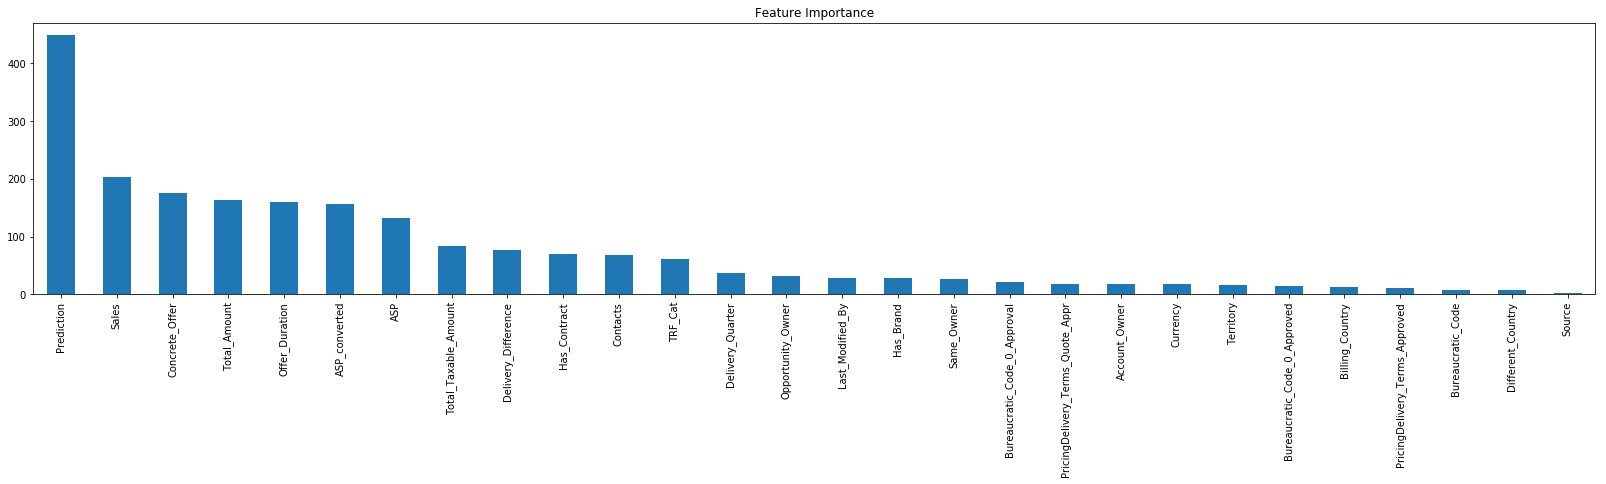

In [63]:
predictors = [x for x in x_t.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

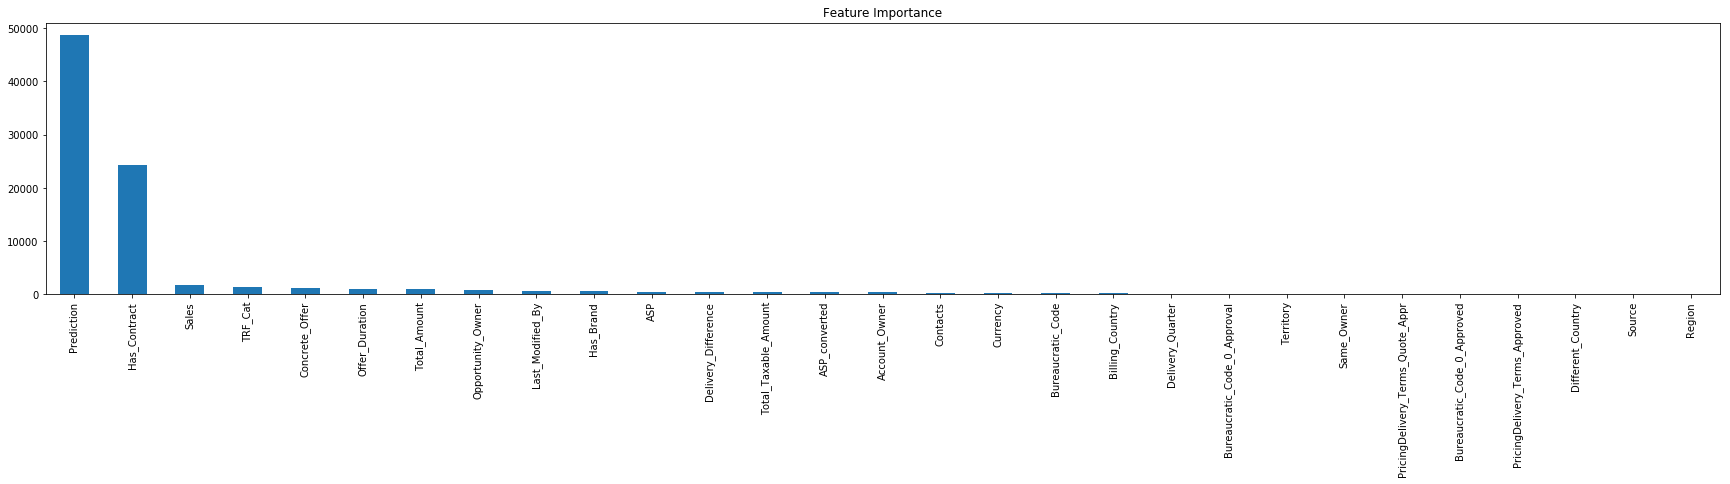

In [83]:
predictors = [x for x in x_t.drop(target, axis = 1).columns]
feat_imp = pd.Series(model2.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [84]:
print feat_imp

Prediction                          48631.298288
Has_Contract                        24341.033149
Sales                                1793.079609
TRF_Cat                              1340.167082
Concrete_Offer                       1131.505506
Offer_Duration                        987.043741
Total_Amount                          925.796565
Opportunity_Owner                     738.413982
Last_Modified_By                      683.328958
Has_Brand                             627.758631
ASP                                   455.858315
Delivery_Difference                   392.692549
Total_Taxable_Amount                  390.804296
ASP_converted                         379.402830
Account_Owner                         358.138387
Contacts                              308.125735
Currency                              248.791013
Bureaucratic_Code                     224.405248
Billing_Country                       197.517623
Delivery_Quarter                      135.226170
Bureaucratic_Code_0_

In [85]:
y_pred = model2.predict(x_ttest.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_ttest.index, columns = ["Def_Prediction"])
aux = x_ttest.join(pred)
answer = aux.groupby("Opportunity_ID")["Stage","Def_Prediction"].mean()
log_loss(answer.Stage, answer.Def_Prediction)

0.0909961823711311

In [87]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

def_pred = model2.predict(validation.drop(leak, axis = 1))
def_pred = pd.DataFrame(def_pred, index = validation.index, columns = ["Def_Prediction"])
aux = validation.join(def_pred)
answer = pd.DataFrame(aux.groupby("Opportunity_ID", as_index = False)["Def_Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer["Def_Prediction"])

0.9865961854833982

In [88]:
answer

,Opportunity_ID,Def_Prediction
0,10689,0.988287
1,10690,0.982522
2,10691,0.971956
3,10692,0.985082
4,10693,0.981591
5,10694,0.982553
6,10695,0.009126
7,10696,0.009730
8,10697,0.013371
9,10698,0.009357


In [89]:
answer.to_csv("submission_20.csv", header = False, index = False)